## Overview
* Country: United States, France, Germany, Japan, United Kingdom, Italy, Canada
* Time period: 1950-2018, 69 years
* Target variable: `ngdp_rpch` for annual data, `ngdp_r_sa_pcha` and `ngdp_r_sa_pchy` (respectively) for quarterly data
* Train-test split: 1950-2009 (train, ≤60 years, depends on data availability), 2010-2018 (test, 9 years)   
  _Need further discussion. Here I divide the dataset by 2009/2010 just as the working paper did. Now for the MA model family we do not need to do such split._

## 1. Get GDP data for all 7 countries

Reference: [IPython Magics for BigQuery](https://googleapis.dev/python/bigquery/latest/magics.html)   
We can also run [parameterized queries](https://cloud.google.com/bigquery/docs/parameterized-queries#bigquery_query_params_arrays-python), but it's not the optimal choice in our case.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%%bigquery gdp_annual
SELECT country, year, ngdp_rpch AS gdp
FROM `deep-nexus.temp_for_imf_data.WEO_G7_Annual`
ORDER BY year

In [3]:
gdp_annual.year = gdp_annual.year.astype(int)
gdp_annual = gdp_annual.pivot(index='year', columns='country', values='gdp')
gdp_annual = gdp_annual.dropna(how='all')
gdp_annual.head()

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1951,4.456157,6.031064,NaN,NaN,NaN,2.094293,10.345388
1952,8.343081,2.554494,NaN,NaN,NaN,0.483864,3.901897
1953,4.972724,2.955828,NaN,NaN,NaN,3.924998,4.003544
1954,-1.094533,4.838707,NaN,NaN,NaN,4.317952,-1.329005
1955,9.520696,5.600003,NaN,NaN,NaN,3.670016,5.555375


Note the percent change data is only available since 1951.

In [4]:
time_len = len(gdp_annual)
time_len

68

Check time period with avaiable GDP data for each country:

In [5]:
len_dict = {country:gdp_annual[country].count() for country in gdp_annual.columns}
len_dict

{'Canada': 68,
 'France': 68,
 'Germany': 58,
 'Italy': 58,
 'Japan': 63,
 'United Kingdom': 68,
 'United States': 68}

## 2. MA

$$ \hat{\mu}_{t+\Delta} = \frac{1}{n} \sum_{i=1}^{n} X_{t-(i-1)\Delta} $$
$$ \hat{\sigma}^2_{t+\Delta} = \frac{1}{n-1} \sum_{i=1}^{n} (X_{t-(i-1)\Delta}-\hat{\mu}_{t+\Delta})^2 $$

>_I choose window size n as 10 years. It's hard to decide the window size for a small dataset, because a long window cuts the dataset even smaller, whereas a short window may lead to unstability. We could discuss the param later._

**Method1. Use a `moving_average_forecast` function similar to the one in the Udacity course**

In [81]:
def moving_average_forecast(df, window_size):
    mov = np.cumsum(df).values
    mov_avg = (mov[window_size:] - mov[:-window_size]) / window_size
    df_mov_avg = pd.DataFrame(data=mov_avg[:-1], index=df.index[window_size+1:], columns=df.columns)
    return df_mov_avg

In [82]:
window_size = 10
forecast_ma = moving_average_forecast(gdp_annual, window_size)
forecast_ma.head(15)

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1962,4.501786,5.061519,NaN,NaN,NaN,2.833933,2.951171
1963,4.366878,5.474401,NaN,NaN,NaN,2.918331,3.164902
1964,4.400302,5.711605,NaN,NaN,NaN,2.921474,3.196806
1965,5.157235,5.879949,NaN,NaN,NaN,3.033417,3.909830
1966,4.841943,5.798314,NaN,NaN,NaN,2.919469,3.994124
1967,4.643956,5.599861,NaN,NaN,9.284698,3.001551,4.444835
1968,4.685977,5.470209,NaN,NaN,9.611543,3.052283,4.528521
1969,4.956900,5.636912,NaN,NaN,10.181241,3.421816,5.081908
1970,5.066230,5.487507,NaN,NaN,10.435038,3.171679,4.425784


**Method2. Use `df.rolling()`**

In [83]:
gdp_annual.rolling(window_size).mean().dropna(how='all')[1:-1].set_index(forecast_ma.index).head(15)

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1962,4.501786,5.061519,NaN,NaN,NaN,2.833933,2.951171
1963,4.366878,5.474401,NaN,NaN,NaN,2.918331,3.164902
1964,4.400302,5.711605,NaN,NaN,NaN,2.921474,3.196806
1965,5.157235,5.879949,NaN,NaN,NaN,3.033417,3.909830
1966,4.841943,5.798314,NaN,NaN,9.009278,2.919469,3.994124
1967,4.643956,5.599861,NaN,NaN,9.284698,3.001551,4.444835
1968,4.685977,5.470209,NaN,NaN,9.611543,3.052283,4.528521
1969,4.956900,5.636912,NaN,NaN,10.181241,3.421816,5.081908
1970,5.066230,5.487507,NaN,NaN,10.435038,3.171679,4.425784


>_The result is exactly the same. I personally prefer this method._

### Plot the forecast versus real data

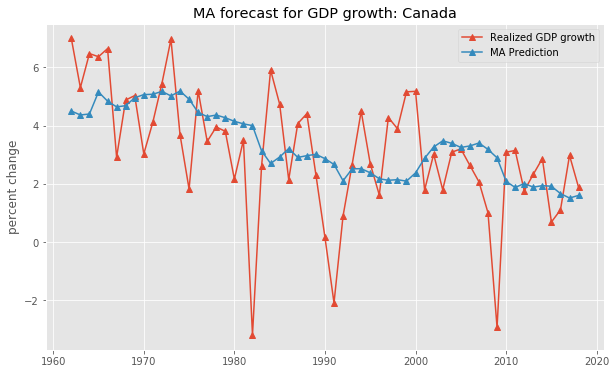

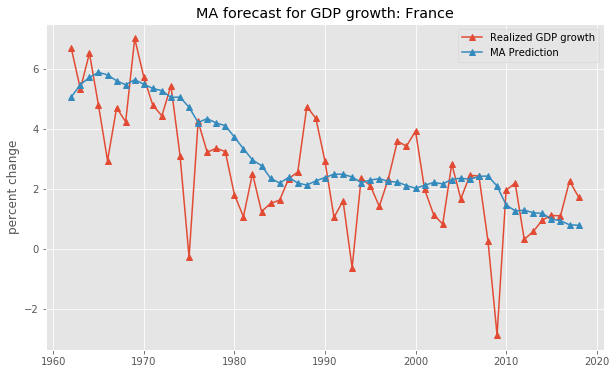

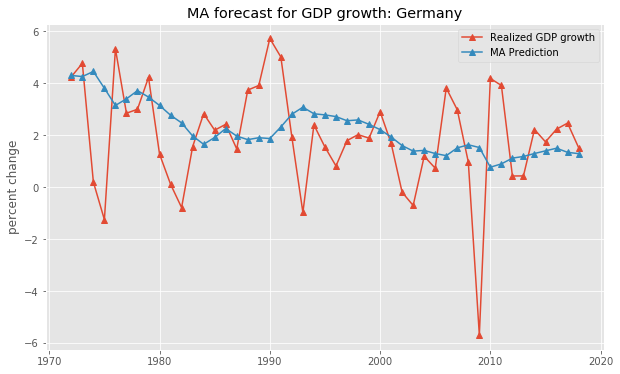

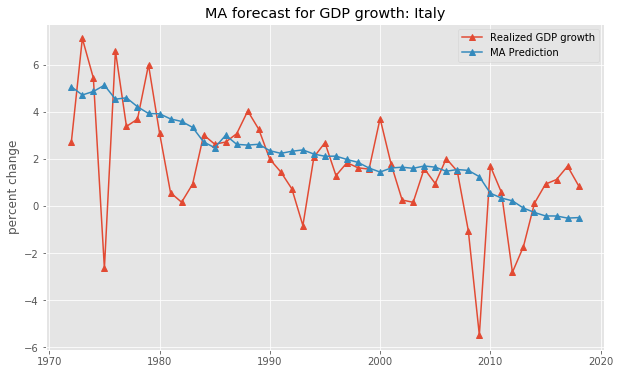

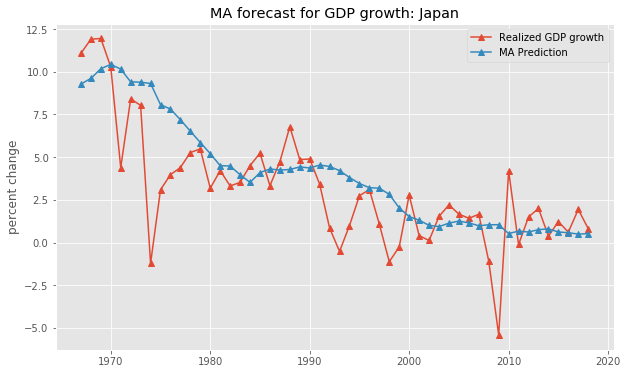

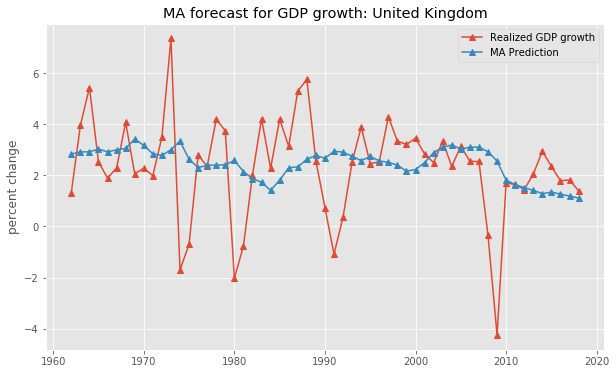

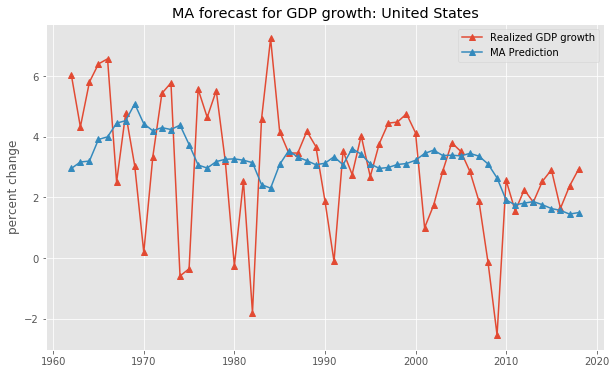

In [84]:
for country in gdp_annual.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(gdp_annual[(window_size+time_len-len_dict[country])+1:][country], marker='^', label='Realized GDP growth')
    plt.plot(forecast_ma[country], marker='^', label='MA Prediction')
    plt.title('MA forecast for GDP growth: ' + country)
    plt.ylabel('percent change')
    plt.legend()
    plt.show()

>_MA is not a good indicator for growth data.   
Usually we use MA for price process or return volatility process, but not for return/growth process._

### Error

In [87]:
df_error_ma = gdp_annual[window_size+1:] - forecast_ma
df_error_ma.head()

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1962,2.492214,1.621798,NaN,NaN,NaN,-1.506082,3.088035
1963,0.940089,-0.146534,NaN,NaN,NaN,1.038099,1.157677
1964,2.074494,0.810541,NaN,NaN,NaN,2.515905,2.604430
1965,1.210538,-1.096297,NaN,NaN,NaN,-0.502882,2.488491
1966,1.803073,-2.858593,NaN,NaN,NaN,-1.027954,2.571670


In [88]:
mae_ma = abs(df_error_ma).mean()
mae_ma

country
Canada            1.485410
France            1.111551
Germany           1.575357
Italy             1.463812
Japan             1.815337
United Kingdom    1.446985
United States     1.640250
dtype: float64

In [89]:
rmse_ma = np.sqrt((df_error_ma**2).mean())
rmse_ma

country
Canada            2.007960
France            1.523832
Germany           2.170515
Italy             2.134035
Japan             2.649910
United Kingdom    2.041418
United States     2.152973
dtype: float64

>_RMSE is much larger than the one used as benchmark in the working paper, which takes an RMSE of 0.72 for United States and 0.63 for United Kingdom. Personally MA is not a good model for growth data. We should use another model as benchmark._

## 3. EWMA

Recursive formula:

$$ \hat{\mu}_{t+\Delta} = \lambda_{1} \mu_{t} + (1-\lambda_{1}) X_{t} $$
$$ \hat{\sigma}^2_{t+\Delta} = \lambda_{2} \sigma^2_{t} + (1-\lambda_{2}) (X_{t}-\mu_{t})^2 $$

Typical value (aka industry convention) of $\lambda$ is 0.97 or 0.94.

Full expression:

$$ \hat{\mu}_{t+\Delta} = \alpha_{0} X_{0} + \sum_{i=1}^{n} \alpha_{i} X_{t-(i-1)\Delta} $$
$$ \hat{\sigma}^2_{t+\Delta} = \alpha_{0} V_{0} + \sum_{i=1}^{n} \alpha_{i} X^2_{t-(i-1)\Delta} $$

where $\alpha_{0}=\lambda^{n}$, $\alpha_{i}=(1-\lambda) \lambda^{i-1}$, $i=1,2,...,n$.

>_Potential problem with EWMA: The initial value $X_{0}$ (or $V_{0}$) is actually the long term mean. It's hard to tell if GDP growth has a long term mean. If not, then it doesn't make sense to take any value as $X_{0}$. The industry convention is to use the average of first $M$ values in the time series as the initial value, where $M$ is often larger than 100._

**Method1. Use a user-defined function to calculate EWMA, similar to MA.**    
Take the average value of first 10 years as $X_{0}$ and then use the recursive formula to make EWMA predictions. The reason for take the initial window size $M$=10 is because we have really limited data in this case. $M$ could be changed.

In [96]:
def weighted_moving_average_forecast(df, window_size, theta):
    def ewma(series):
        start_loc = series.index.get_loc(series.first_valid_index())
        end_loc = start_loc + window_size
        mov = np.array(series)
        miu = mov[start_loc:end_loc].mean()
        mov[start_loc:end_loc] = np.nan
        for loc in range(0, len(mov[end_loc:])):
            miu = theta*miu + (1-theta)*mov[end_loc+loc]
            mov[end_loc+loc] = miu
        series_mov = pd.Series(data=mov, index=series.index)
        return series_mov
    return df.apply(ewma).dropna(how='all')

In [92]:
window_size = 10
theta1, theta2 = 0.97, 0.94

In [97]:
forecast_ewma97 = weighted_moving_average_forecast(gdp_annual, window_size, theta1)
forecast_ewma94 = weighted_moving_average_forecast(gdp_annual, window_size, theta2)

In [98]:
forecast_ewma97.head(15)

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1961,4.588948,5.125245,NaN,NaN,NaN,2.779634,3.710103
1962,4.661100,5.171987,NaN,NaN,NaN,2.736081,3.779977
1963,4.680476,5.176664,NaN,NaN,NaN,2.772691,3.796255
1964,4.734306,5.217028,NaN,NaN,NaN,2.852632,3.856404
1965,4.783310,5.204027,NaN,NaN,NaN,2.842969,3.932662
1966,4.839161,5.136098,NaN,NaN,9.046452,2.814425,4.011656
1967,4.781447,5.123069,NaN,NaN,9.107578,2.798743,3.966505
1968,4.784403,5.096411,NaN,NaN,9.191619,2.837003,3.990558
1969,4.791860,5.153870,NaN,NaN,9.274465,2.813759,3.962004


In [99]:
forecast_ewma94.head(15)

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1961,4.543975,5.137270,NaN,NaN,NaN,2.773260,3.667385
1962,4.690976,5.230033,NaN,NaN,NaN,2.686535,3.809695
1963,4.727936,5.235903,NaN,NaN,NaN,2.762729,3.840468
1964,4.832747,5.313078,NaN,NaN,NaN,2.923208,3.958114
1965,4.924849,5.281312,NaN,NaN,NaN,2.899648,4.104526
1966,5.028059,5.140817,NaN,NaN,9.083626,2.839160,4.252202
1967,4.901297,5.114476,NaN,NaN,9.203649,2.806311,4.147469
1968,4.900018,5.061677,NaN,NaN,9.365965,2.882378,4.184717
1969,4.907996,5.178678,NaN,NaN,9.521196,2.833167,4.115958


**Method2. Use `df.ewm()`**   

Note: `df.ewm()` automatically takes the first non-null value as the initial value $X_{0}$. If we don't care much about the validity of a long term mean (as it may not exist in essence), then it doesn't hurt much to use it. Note that the results are slightly different from the ones generated by the `weighted_moving_average_forecast` function.

**EWMA97:**

In [152]:
gdp_annual.ewm(min_periods=window_size, alpha=1-theta1).mean().dropna(how='all')[:-1].set_index(forecast_ewma97.index).head(15)

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1961,4.558206,5.195216,NaN,NaN,NaN,2.835984,3.684379
1962,4.408215,5.228814,NaN,NaN,NaN,2.808329,3.541544
1963,4.661593,5.371339,NaN,NaN,NaN,2.663258,3.786287
1964,4.720806,5.367350,NaN,NaN,NaN,2.781908,3.835492
1965,4.872377,5.467141,NaN,NaN,NaN,3.011379,4.005361
1966,4.994700,5.411232,NaN,NaN,9.029404,2.972046,4.201105
1967,5.123047,5.219019,NaN,NaN,9.157857,2.888012,4.385010
1968,4.959180,5.180629,NaN,NaN,9.346598,2.843749,4.245587
1969,4.953551,5.113375,NaN,NaN,9.581693,2.931204,4.282741


**EWMA94:**

In [151]:
gdp_annual.ewm(min_periods=window_size, alpha=1-theta2).mean().dropna(how='all')[:-1].set_index(forecast_ewma94.index).head(15)

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
year,,,,,,,
1961,4.477941,5.282967,NaN,NaN,NaN,2.890408,3.627256
1962,4.314707,5.311051,NaN,NaN,NaN,2.851899,3.469464
1963,4.621450,5.468157,NaN,NaN,NaN,2.677416,3.763664
1964,4.695877,5.452926,NaN,NaN,NaN,2.816279,3.824346
1965,4.880069,5.563635,NaN,NaN,NaN,3.087673,4.029037
1966,5.027681,5.486244,NaN,NaN,9.039731,3.032393,4.264120
1967,5.182099,5.243110,NaN,NaN,9.186623,2.923465,4.483877
1968,4.973093,5.193199,NaN,NaN,9.403848,2.865211,4.301565
1969,4.964776,5.107559,NaN,NaN,9.675826,2.973199,4.343255


### Plot the forecast versus real data   
Use the results in method1.

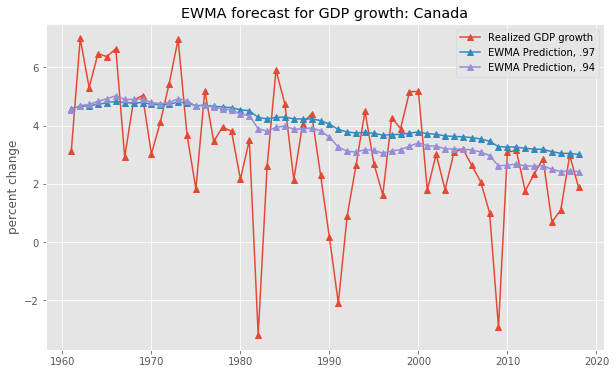

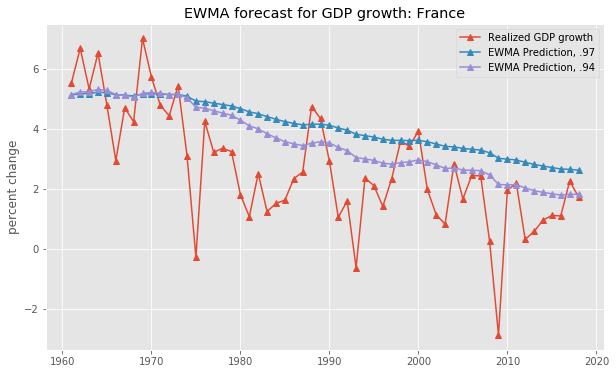

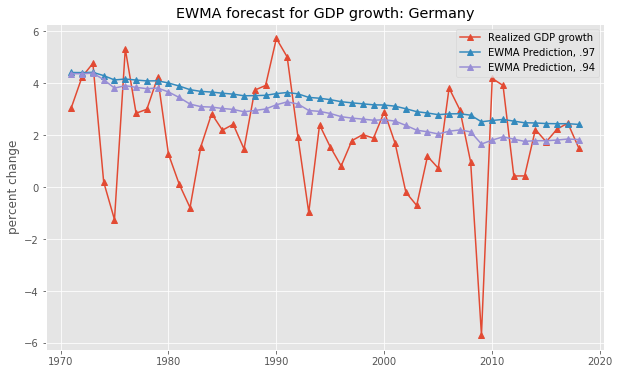

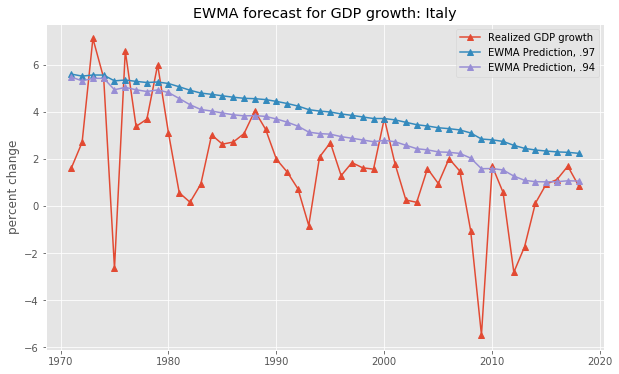

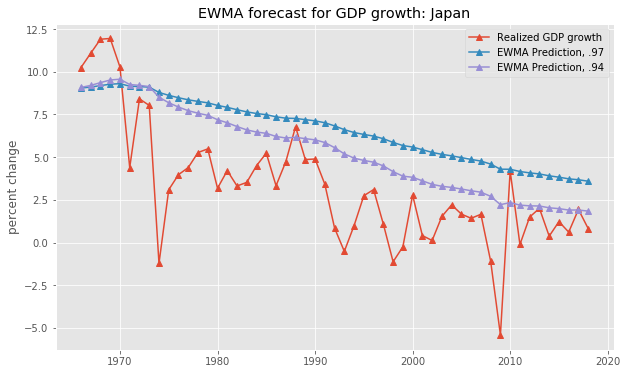

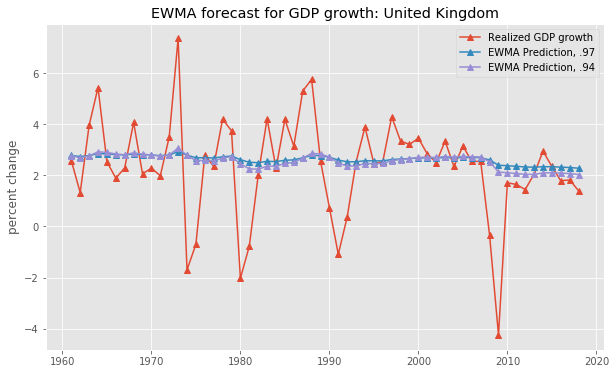

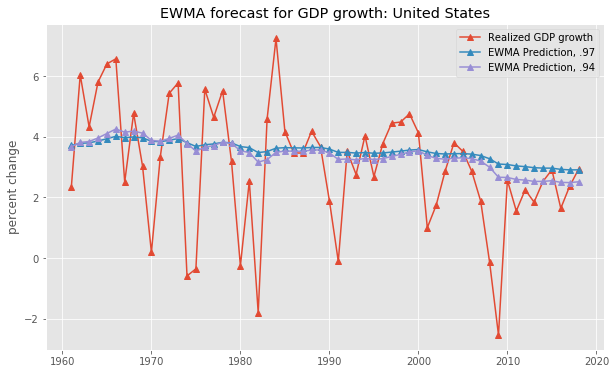

In [100]:
for country in gdp_annual.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(gdp_annual[(window_size+time_len-len_dict[country]):][country], marker='^', label='Realized GDP growth')
    plt.plot(forecast_ewma97[country], marker='^', label='EWMA Prediction, .97')
    plt.plot(forecast_ewma94[country], marker='^', label='EWMA Prediction, .94')
    plt.title('EWMA forecast for GDP growth: ' + country)
    plt.ylabel('percent change')
    plt.legend()
    plt.show()

>_Still not good enough._

### Error

In [154]:
df_error_ewma97 = gdp_annual[window_size:] - forecast_ewma97
df_error_ewma94 = gdp_annual[window_size:] - forecast_ewma94

In [155]:
mae_ewma = pd.DataFrame([abs(df_error_ewma97).mean(),abs(df_error_ewma94).mean()], index=['EWMA97', 'EWMA94']).T
mae_ewma

,EWMA97,EWMA94
country,,
Canada,1.537227,1.384351
France,1.636079,1.256957
Germany,1.784337,1.553890
Italy,2.496233,1.783621
Japan,3.665922,2.543824
United Kingdom,1.281124,1.238935
United States,1.475730,1.402573


In [156]:
rmse_ewma = pd.DataFrame([np.sqrt((df_error_ewma97**2).mean()),np.sqrt((df_error_ewma94**2).mean())], index=['EWMA97', 'EWMA94']).T
rmse_ewma

,EWMA97,EWMA94
country,,
Canada,2.103746,1.910175
France,2.037558,1.644985
Germany,2.373039,2.100030
Italy,3.027347,2.415550
Japan,4.168959,3.147018
United Kingdom,1.896383,1.844183
United States,1.999630,1.912614


>_Prediction power: EWMA94 > EWMA97 > MA. Difference is not significant.   
We need to look for other time series models as benchmark..._

## 4. ARMA

Use expanding windows (instead of rolling windows) to fully utilize avaiable data.

In [116]:
from statsmodels.tsa.arima_model import ARMA

In [117]:
train_arma = gdp_annual[:int(0.7*(len(gdp_annual)))].T.values
test_arma = gdp_annual[int(0.7*(len(gdp_annual))):].T.values

In [21]:
arma_model = ARMA(train_arma[0], order=(1,1))

In [22]:
arma_result = arma_model.fit()

In [25]:
arma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:                     ARMA(1, 1)   Log Likelihood                -106.040
Method:                       css-mle   S.D. of innovations              2.251
Date:                Mon, 18 Nov 2019   AIC                            220.081
Time:                        04:07:16   BIC                            227.481
Sample:                             0   HQIC                           222.866
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8240      0.401      9.546      0.000       3.039       4.609
ar.L1.y       -0.6356      0.119     -5.342      0.000      -0.869      -0.402
ma.L1.y        1.0000      0.177      5.663      0.000       0.654       1.346
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5733           +0.0000j            1.5733            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In [30]:
arma_pred, _, _ = arma_result.forecast(test_arma.shape[1])

In [31]:
arma_pred

array([4.60442026, 3.3278884 , 4.13924778, 3.62355047, 3.95132596,
       3.74299295, 3.87540871, 3.7912457 , 3.84473943, 3.81073899,
       3.83234956, 3.81861396, 3.82734426, 3.82179531, 3.8253222 ,
       3.82308052, 3.82450532, 3.82359972, 3.82417532, 3.82380947,
       3.824042  ])

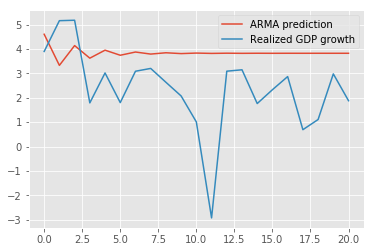

In [34]:
plt.plot(arma_pred, label='ARMA prediction')
plt.plot(test_arma[0], label='Realized GDP growth')
plt.legend()
plt.show()

In [10]:
for i in range(0, train_arma.shape[0]):
    arma_model = ARMA(train_arma[i], order=(1,1))
    arma_result = arma_model.fit()
    arma_pred = arma_result.forecast(test_arma[i])

ValueError: endog must be 1-d or 2-d with 1 column

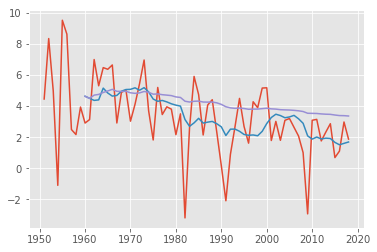

In [37]:
plt.plot(gdp_annual.Canada)
plt.plot(gdp_annual.Canada.rolling(10).mean())
plt.plot(gdp_annual.Canada.expanding(10).mean())